In [1]:
import matplotlib.pyplot as plt
import torch

from data.reshape_data import reshape
from data.poisson_data_v import PoissonTimeShiftedData
from utils.funcs import shuffle_back
from boltzmann_machines.cp_rtrbm import RTRBM

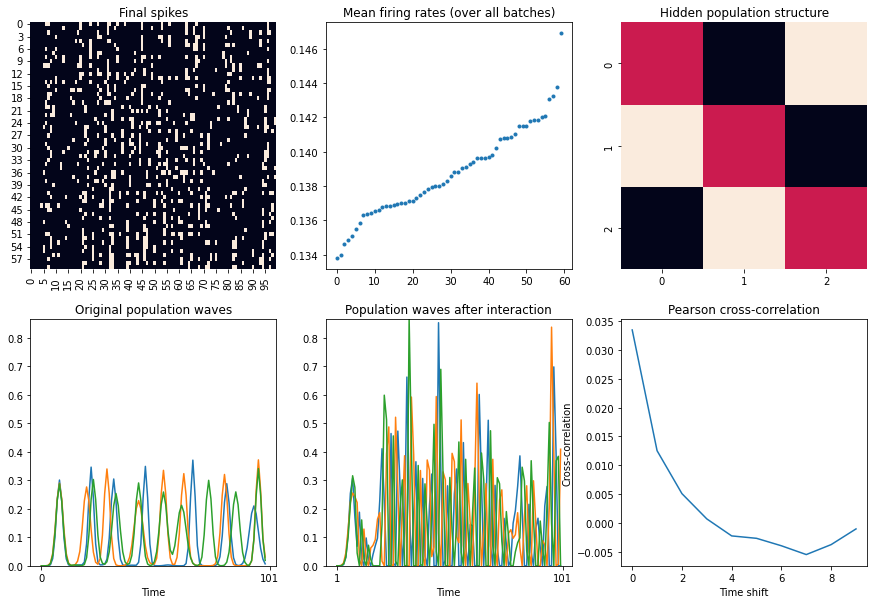

In [3]:
n_h = 3
T=35000
n_batches=1
delay = 1
norm = 0.80
temporal_connections = torch.tensor([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
]).float()/0.36
frequency_range = [5, 10]
phase_range = [0, torch.pi]
amplitude_range = [0.4, 0.5]
gaus = PoissonTimeShiftedData(
    neurons_per_population=20,
    n_populations=n_h,
    n_batches=n_batches, time_steps_per_batch=T,
    fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
    frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range)

axes = gaus.plot_stats(T=100)
plt.show()

100%|██████████| 200/200 [16:06<00:00,  4.83s/it]


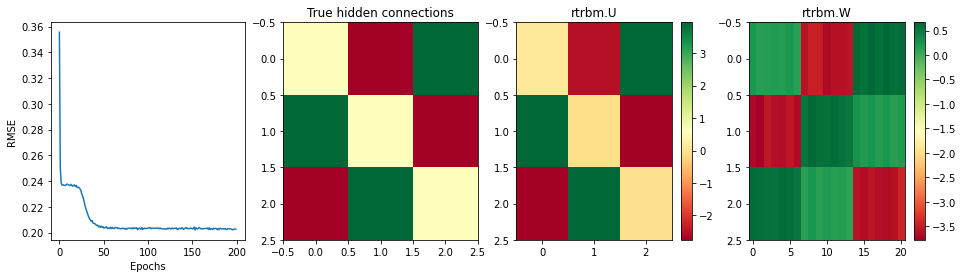

100%|██████████| 200/200 [15:44<00:00,  4.72s/it]


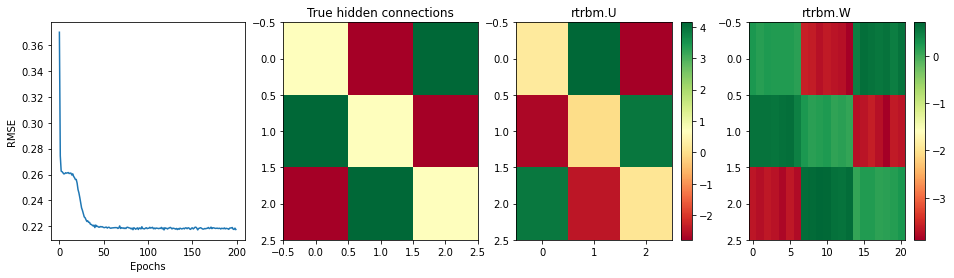

100%|██████████| 200/200 [15:49<00:00,  4.75s/it]


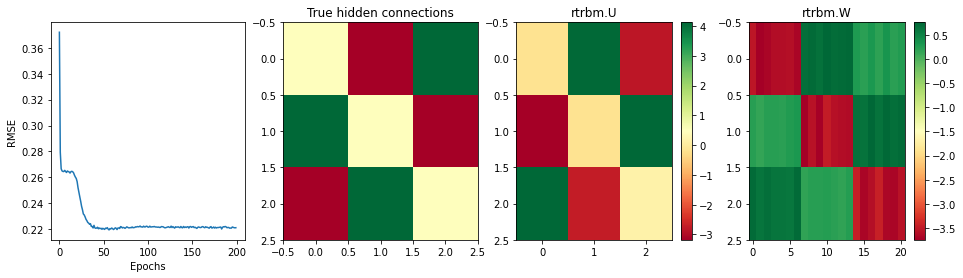

100%|██████████| 200/200 [15:43<00:00,  4.72s/it]


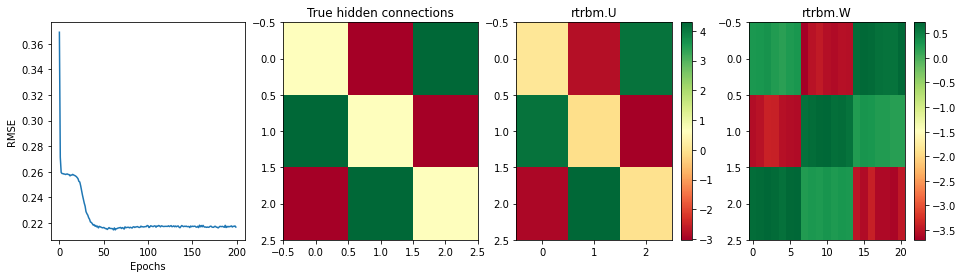

100%|██████████| 200/200 [15:31<00:00,  4.66s/it]


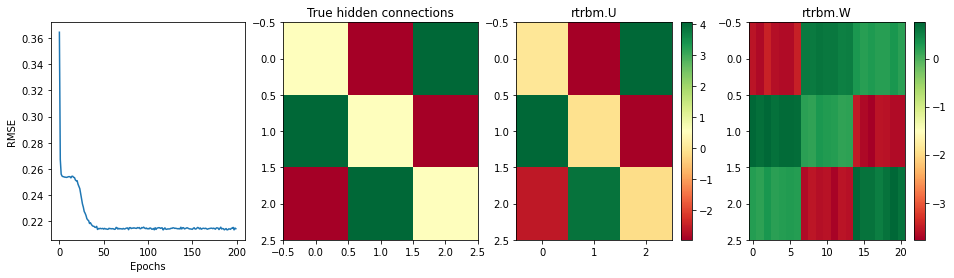

100%|██████████| 200/200 [15:39<00:00,  4.70s/it]


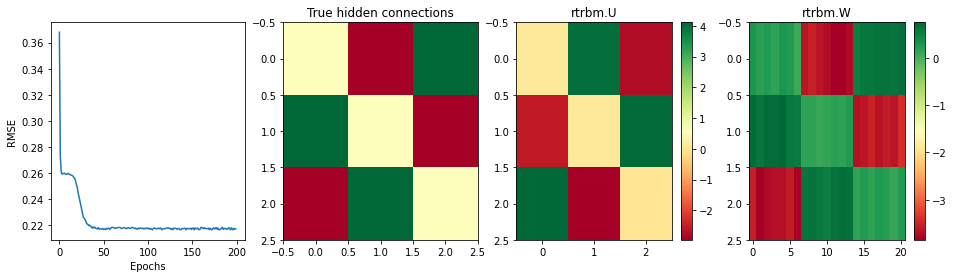

100%|██████████| 200/200 [15:31<00:00,  4.66s/it]


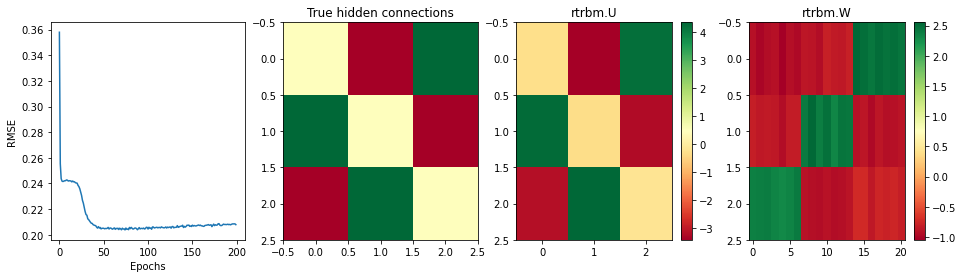

100%|██████████| 200/200 [15:33<00:00,  4.67s/it]


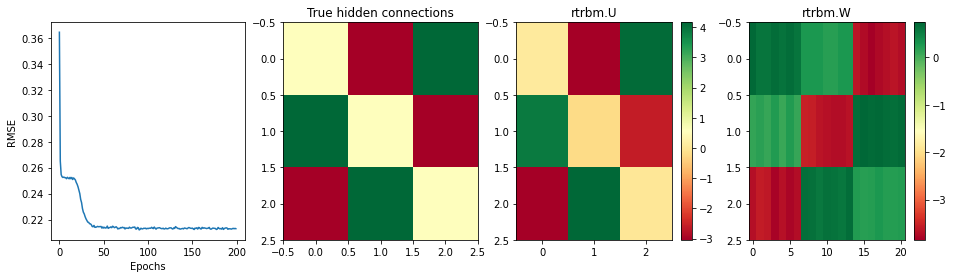

100%|██████████| 200/200 [15:34<00:00,  4.67s/it]


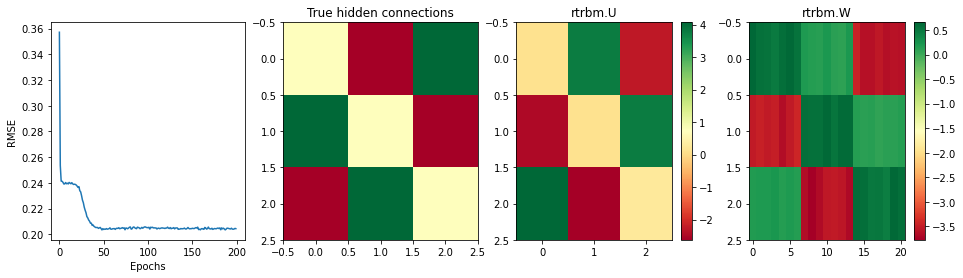

100%|██████████| 200/200 [15:30<00:00,  4.65s/it]


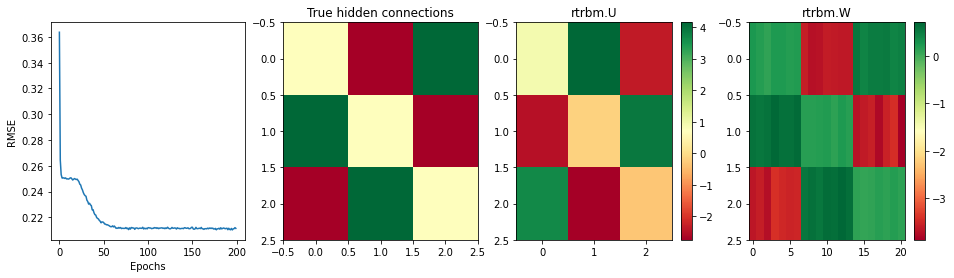

In [11]:
rtrbm_list = []
n_runs = 10
for i in range(n_runs):
    gaus = PoissonTimeShiftedData(
        neurons_per_population=7,
        n_populations=n_h,
        n_batches=n_batches, time_steps_per_batch=T,
        fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
        frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range)

    data = reshape(gaus.data[..., 0], T=100, n_batches=350)
    train, test = data[..., :280], data[..., 280:]

    rtrbm_gaus = RTRBM(train, N_H=n_h, device="cpu")
    rtrbm_gaus.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=0, x=1)

    W, U = shuffle_back(rtrbm_gaus.W, rtrbm_gaus.U, gaus.temporal_connections)

    rtrbm_list += [rtrbm_gaus]

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].plot(rtrbm_gaus.errors)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('RMSE')
    ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    ax[1].set_title('True hidden connections')
    cm = ax[2].imshow(U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    fig.colorbar(cm, ax=ax[2])
    ax[2].set_title('rtrbm.U')
    cm = ax[3].imshow(W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    fig.colorbar(cm, ax=ax[3])
    ax[3].set_title('rtrbm.W')

    plt.show()

100%|██████████| 200/200 [16:51<00:00,  5.06s/it]


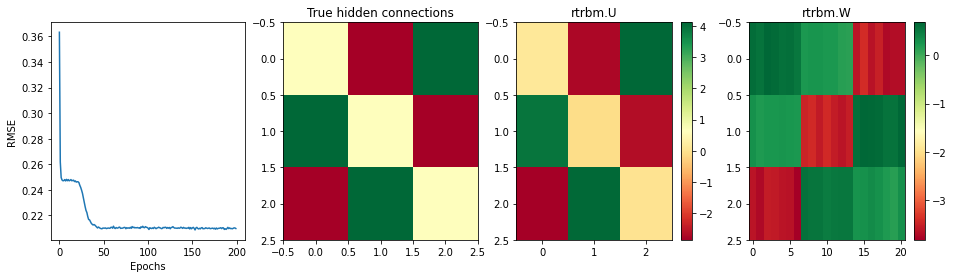

In [5]:
gaus = PoissonTimeShiftedData(
    neurons_per_population=7,
    n_populations=n_h,
    n_batches=n_batches, time_steps_per_batch=T,
    fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
    frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range)

data = reshape(gaus.data[..., 0], T=100, n_batches=350)
train, test = data[..., :280], data[..., 280:]

rtrbm_gaus = RTRBM(train, N_H=n_h, device="cpu")
rtrbm_gaus.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=0, x=1)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(rtrbm_gaus.errors)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('RMSE')
ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
ax[1].set_title('True hidden connections')
cm = ax[2].imshow(rtrbm_gaus.U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
fig.colorbar(cm, ax=ax[2])
ax[2].set_title('rtrbm.U')
cm = ax[3].imshow(rtrbm_gaus.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
fig.colorbar(cm, ax=ax[3])
ax[3].set_title('rtrbm.W')

plt.show()

100%|██████████| 200/200 [24:50<00:00,  7.45s/it]


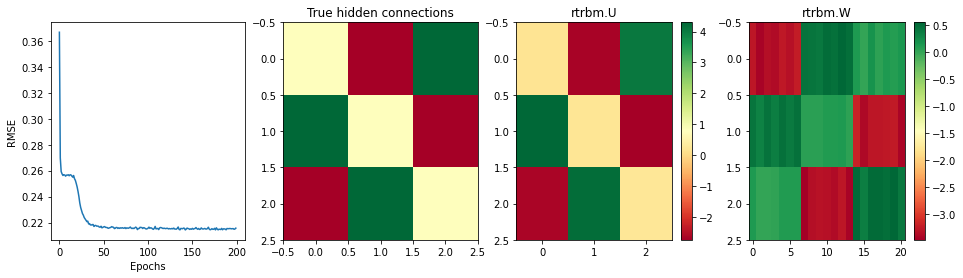

In [6]:
gaus = PoissonTimeShiftedData(
    neurons_per_population=7,
    n_populations=n_h,
    n_batches=n_batches, time_steps_per_batch=T,
    fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
    frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range)

data = reshape(gaus.data[..., 0], T=100, n_batches=350)
train, test = data[..., :280], data[..., 280:]

rtrbm_gaus = RTRBM(train, N_H=n_h, device="cpu")
rtrbm_gaus.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=1e-4, x=1)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(rtrbm_gaus.errors)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('RMSE')
ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
ax[1].set_title('True hidden connections')
cm = ax[2].imshow(rtrbm_gaus.U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
fig.colorbar(cm, ax=ax[2])
ax[2].set_title('rtrbm.U')
cm = ax[3].imshow(rtrbm_gaus.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
fig.colorbar(cm, ax=ax[3])
ax[3].set_title('rtrbm.W')

plt.show()